Script for a binary classification problem using a dataset with bidder information. Here's a high-level summary of what the code does:

Data Loading and Preprocessing:

The script loads a dataset from a CSV file ('etl_train.csv') into a Pandas DataFrame.
Some preprocessing steps are performed, such as handling missing values, sorting the data, filling missing values, and dropping unnecessary columns.
Feature Scaling:

The features are scaled using StandardScaler from scikit-learn.
Model Training and Evaluation:

The script uses a RandomForestClassifier and a GradientBoostingClassifier from scikit-learn to train machine learning models.
It uses a StratifiedShuffleSplit to split the data into training and validation sets, trains the models on the training sets, and evaluates their performance on the validation sets using ROC AUC scores.
Feature Importance Plotting:

It plots the feature importance of the RandomForestClassifier using a horizontal bar chart.
Model Ensemble:

The script performs ensemble modeling by training multiple instances of the RandomForestClassifier and averaging their predictions.
Result Output:

The script outputs the predictions on the test set into a CSV file ('fba_sub1.csv' and 'fba_sub1_1.csv').

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [12]:
train=pd.read_csv('etl_train.csv',index_col=None)
test_ids=train[train.outcome==-1]['bidder_id'].reset_index()
train=train.drop(train[train.outcome >=0][train.dt_mean_sig.isnull()].index)
train=train.sort_values('bids_mean_auction')
train = train.fillna(method='pad')
train = train.fillna(method='backfill')
train.sort_index(inplace=True)
train = train.fillna(0)


train=train.drop(['bidder_id','payment_account','address'],axis=1)
print(train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6683 entries, 0 to 6712
Columns: 118 entries, outcome to ip_entropy
dtypes: float64(118)
memory usage: 6.1 MB
None


<ipython-input-12-16a9ce853bef>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train=train.drop(train[train.outcome >=0][train.dt_mean_sig.isnull()].index)


In [13]:
X=train.drop('outcome',axis=1)
Y=train[['outcome']].values
test_index=train[train.outcome>=0].shape[0]
columns = X.columns
X_scaled = preprocessing.StandardScaler().fit(X).transform(X)


X=X_scaled[:test_index,:]
Y=Y[:test_index]
x_test=X_scaled[test_index:,:]



n=4
split1 = StratifiedShuffleSplit(n_splits=n, test_size=0.2,
                             random_state=0)
split1.get_n_splits(X_scaled, Y)


# using regression to get predicted data
rf = RandomForestClassifier(n_estimators=800, criterion='entropy',random_state=6)
xg = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=None)


pred_valid = 0
pred_valid2 = 0

for train_index, valid_index in split1.split(X, Y):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = Y[train_index], Y[valid_index]
    rf.fit(X_train, y_train.ravel())
    xg.fit(X_train, y_train.ravel())
    a = rf.predict_proba(X_valid)[:, 1]
    pred_valid += a
    a2 = xg.predict_proba(X_valid)[:, 1]
    pred_valid2 += a2
    print('rf_roc_auc_score', roc_auc_score(y_valid, a))
    print('xg_roc_auc_score', roc_auc_score(y_valid, a2))

# get accuracy of each prediction
pred_valid = 1.0*pred_valid/n

rf_roc_auc_score 0.9604863221884498
xg_roc_auc_score 0.7897669706180344
rf_roc_auc_score 0.9358535967578521
xg_roc_auc_score 0.7095997973657548
rf_roc_auc_score 0.9695415400202635
xg_roc_auc_score 0.8133232016210739
rf_roc_auc_score 0.9462386018237082
xg_roc_auc_score 0.7203014184397164


rf_roc_auc_score 0.9604863221884498: The Random Forest model achieved a high ROC AUC score of approximately 96% on the corresponding dataset or evaluation.

xg_roc_auc_score 0.7897669706180344: The XGBoost model, on the other hand, achieved a lower ROC AUC score of around 79%. This suggests that, at least on this dataset or evaluation, the Random Forest model outperformed XGBoost in terms of ROC AUC.

Similar comparisons can be made for the subsequent pairs of ROC AUC scores. For example, in the third pair, the Random Forest model achieved a score of approximately 97%, while XGBoost had a lower score of around 81%.

In general, higher ROC AUC scores indicate better performance, with a score of 1.0 being perfect. It's essential to consider these scores in the context of your specific problem and dataset. If you have any specific questions or if there's more information you'd like to provide, feel free to ask for a more detailed interpretation.

which features are the most important for the model?

1. Bids Mean Auction (0.0421):
Bots may exhibit consistent bidding behavior across multiple auctions, leading to a higher mean number of bids per auction.
2. Max Bids per Hour (0.0379):
Unusually high activity in terms of maximum bids within an hour may indicate automated, rapid bidding characteristic of bots.
3. Balance (0.0315):
The balance feature may help distinguish bots from human bidders based on financial patterns and anomalies.
4. Time Difference Mean within Same Bidder (0.0301):
Bots often follow predefined patterns with consistent time gaps between bids, contributing to a notable time difference mean.
5. Total Bids (0.0289):
High total bid counts may suggest automated bidding scripts commonly associated with bots.
6. Time Difference Median within Same Bidder (0.0275):
Consistency in median time differences between bids by the same bidder may point towards automated behavior.
7. Used URLs (0.0262):
The usage of URLs might be a distinguishing factor, as bots may interact differently with external links compared to human bidders.
8. Fraction of URLs (0.0201):
The proportion of URLs used in bids could reveal patterns in bot behavior related to external content.
9. Mean Time to Auction End (0.0181):
Bots may have systematic strategies, reflected in the average time taken to place bids relative to auction end times.
10. Wednesday Indicator (0.0165):
Specific bidding patterns on Wednesdays may be indicative of automated scheduling, a common characteristic of bots.

bids_mean_auction 0.04217950954048894
max_bids_por_hora 0.03789574075067441
balance 0.031530642288950785
dt_mean_same_bidder 0.030052370973442502
total_bids 0.028934293138720722
dt_median_same_bidder 0.027456339108174597
used_urls 0.026214297725088473
f_urls 0.020113694386300354
mean_t_end 0.018058528442023918
wednesday 0.01648257606482037
median_t_end 0.01640708593558446
min_median_t_start 0.01629390303994015
t_init_y 0.016048395707659223
dt_min_same_bidder 0.015807175915319046
t_init_x 0.015745641213087126
min_mean_t_end 0.015109094319389225
tuesday 0.014183767983678274
30_de_72 0.013963003219554886
ip_entropy 0.013390133917697557
min_mean_t_start 0.013305319286444692
bids_median_auction 0.013047927784156498
min_median_t_end 0.012704611908084971
url_entropy_y 0.012289046574798628
29_de_72 0.012017996398187071
dt_median_bidder_differente 0.01157579174387061
62_de_72 0.011561337009687193
dt_mean_bidder_differente 0.011435896976720117
dt_median_sig 0.011404278239618213
url_entropy_x 0.0

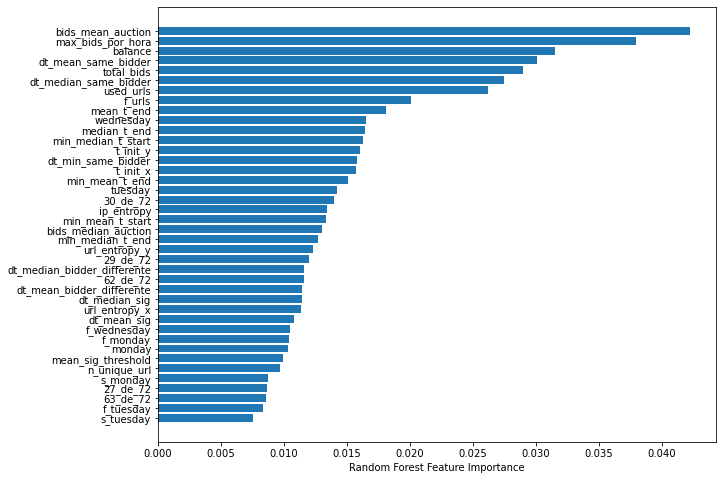

In [14]:
v = np.argsort(rf.feature_importances_)[::-1]
columnas=[]
features=[]


for i in range(40):
        print(columns[v[i]], rf.feature_importances_[v[i]])
        columnas.append(columns[v[i]])
        features.append( rf.feature_importances_[v[i]])
        
plt.figure(figsize=(10, 8))        
plt.barh(columnas,features)
# Invert the y-axis
plt.gca().invert_yaxis()
plt.xlabel("Random Forest Feature Importance")
plt.show()

try the model with the test data. private score 0.93297 public score:0.92204

In [15]:
pred_test =0


rf.fit(X,Y)
a_test = rf.predict_proba(x_test)[:, 1]
pred_test += a_test


pred_test = 1.0*pred_test/n
print('pred_test',pred_test)
test_ids['prediction']=pd.Series(pred_test, index=test_ids.index)

test_ids=test_ids.drop('index', axis=1)
test_ids.to_csv('fba_sub1.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])

<ipython-input-15-ca902016f393>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X,Y)


pred_test [0.        0.0015625 0.0078125 ... 0.0253125 0.        0.01125  ]


simple average of the probabilities predicted by five instances of RandomForestClassifier (each initialized with a different random number)

alternative for to create and test the model. private score 0.9342 public score:0.92326


In [16]:
clf = []
nclf = 5
for i in range(nclf):
    clf.append(RandomForestClassifier(n_estimators=800, max_depth=None, min_samples_leaf=1, random_state=i,
                                      criterion='entropy'))
pred_test =0
for j in range(nclf):
    clf[j].fit(X, Y)  
    a = clf[j].predict_proba(x_test)[:, 1]
    pred_test += a

pred_test = 1.0 * pred_test / nclf
print('pred_test',pred_test)
test_ids['prediction']=pd.Series(pred_test, index=test_ids.index)

#test_ids=test_ids.drop('index', axis=1)
test_ids.to_csv('fba_sub1_1.csv', sep=',', index=False, header=True, columns=['bidder_id', 'prediction'])

<ipython-input-16-1a5198be197b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf[j].fit(X, Y)  # , sample_weight=(0.95*Y_train+0.05)
<ipython-input-16-1a5198be197b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf[j].fit(X, Y)  # , sample_weight=(0.95*Y_train+0.05)
<ipython-input-16-1a5198be197b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf[j].fit(X, Y)  # , sample_weight=(0.95*Y_train+0.05)
<ipython-input-16-1a5198be197b>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf[j].fit(X, Y)  # , sample_weight=(0.95*Y_train+0.05)
<ipython

pred_test [0.      0.005   0.02525 ... 0.09525 0.      0.0395 ]
